In [10]:
!pip install librosa soundfile torchaudio datasets transformers matplotlib seaborn scikit-learn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import torch
import torchaudio
from datasets import load_dataset, Dataset, Audio
import warnings
warnings.filterwarnings('ignore')

def create_swahili_speech_dataset():
    swahili_words = ['jambo', 'asante', 'rafiki', 'nyumba', 'shule', 'kitabu', 'maji', 'chakula']

    def generate_synthetic_audio(text, duration=2.0, sr=16000):
        t = np.linspace(0, duration, int(sr * duration))
        freq_map = {
            'jambo': 220, 'asante': 260, 'rafiki': 300, 'nyumba': 340,
            'shule': 380, 'kitabu': 420, 'maji': 460, 'chakula': 500
        }
        freq = freq_map.get(text, 440)
        audio = 0.5 * np.sin(2 * np.pi * freq * t)
        noise = 0.1 * np.random.normal(0, 1, len(audio))
        audio = audio + noise
        audio = audio / np.max(np.abs(audio))
        return audio

    train_samples = []
    val_samples = []
    samples_per_word = 15

    for word in swahili_words:
        for i in range(samples_per_word):
            duration = np.random.uniform(1.5, 2.5)
            audio = generate_synthetic_audio(word, duration)

            sample = {
                'audio': {
                    'array': audio,
                    'sampling_rate': 16000,
                    'path': f"synthetic_{word}_{i}.wav"
                },
                'text': word,
                'label': word,
                'duration': duration
            }

            if i < samples_per_word * 0.8:
                train_samples.append(sample)
            else:
                val_samples.append(sample)

    return {'train': train_samples, 'validation': val_samples}

dataset = create_swahili_speech_dataset()

In [11]:
# Inspect metadata
print("Audio Metadata Inspection:")
print("=" * 40)

sample = dataset['train'][0]
audio_data = sample['audio']['array']
sr = sample['audio']['sampling_rate']
print(f"Sampling rate: {sr} Hz")
print(f"Audio duration: {sample['duration']:.2f} seconds")
print(f"Audio shape: {audio_data.shape}")
print(f"Number of training samples: {len(dataset['train'])}")
print(f"Number of validation samples: {len(dataset['validation'])}")

# Label distribution
all_labels = []
for split_name, samples in dataset.items():
    all_labels.extend([sample['label'] for sample in samples])
unique_labels, counts = np.unique(all_labels, return_counts=True)

print(f"\nLabel distribution:")
for label, count in zip(unique_labels, counts):
    print(f"  {label}: {count} samples")

Audio Metadata Inspection:
Sampling rate: 16000 Hz
Audio duration: 1.93 seconds
Audio shape: (30827,)
Number of training samples: 96
Number of validation samples: 24

Label distribution:
  asante: 15 samples
  chakula: 15 samples
  jambo: 15 samples
  kitabu: 15 samples
  maji: 15 samples
  nyumba: 15 samples
  rafiki: 15 samples
  shule: 15 samples


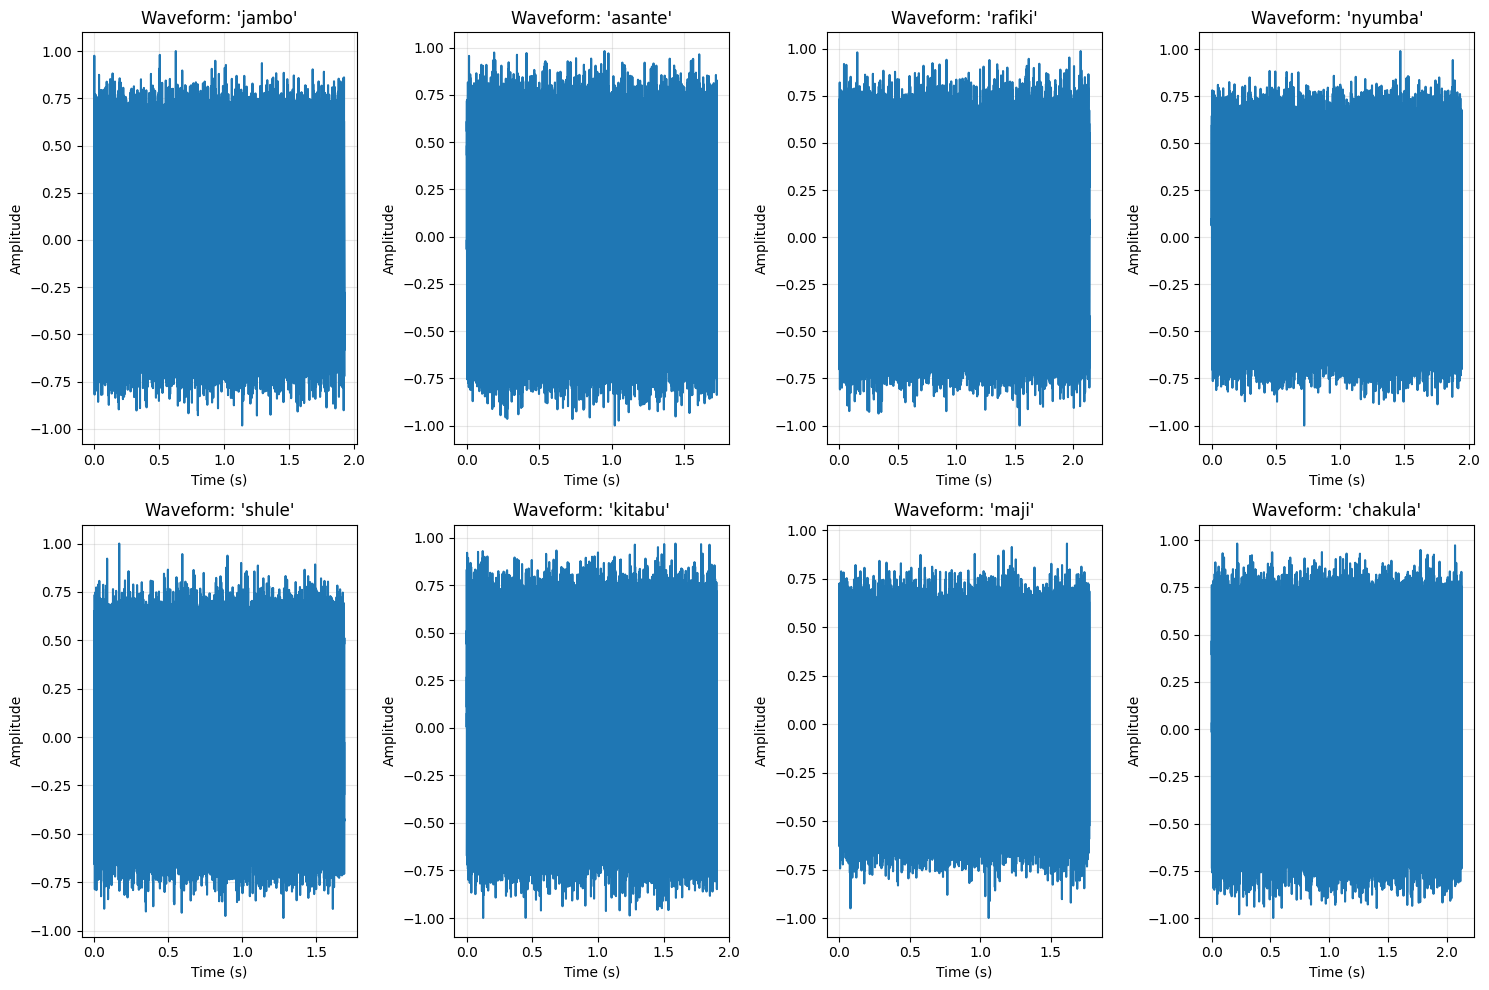

In [12]:
# Visualize waveforms
plt.figure(figsize=(15, 10))
class_samples = {}
for sample in dataset['train']:
    label = sample['label']
    if label not in class_samples:
        class_samples[label] = sample

for i, (label, sample) in enumerate(class_samples.items()):
    plt.subplot(2, 4, i+1)
    audio_data = sample['audio']['array']
    sr = sample['audio']['sampling_rate']
    time = np.linspace(0, len(audio_data) / sr, len(audio_data))
    plt.plot(time, audio_data)
    plt.title(f"Waveform: '{label}'")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

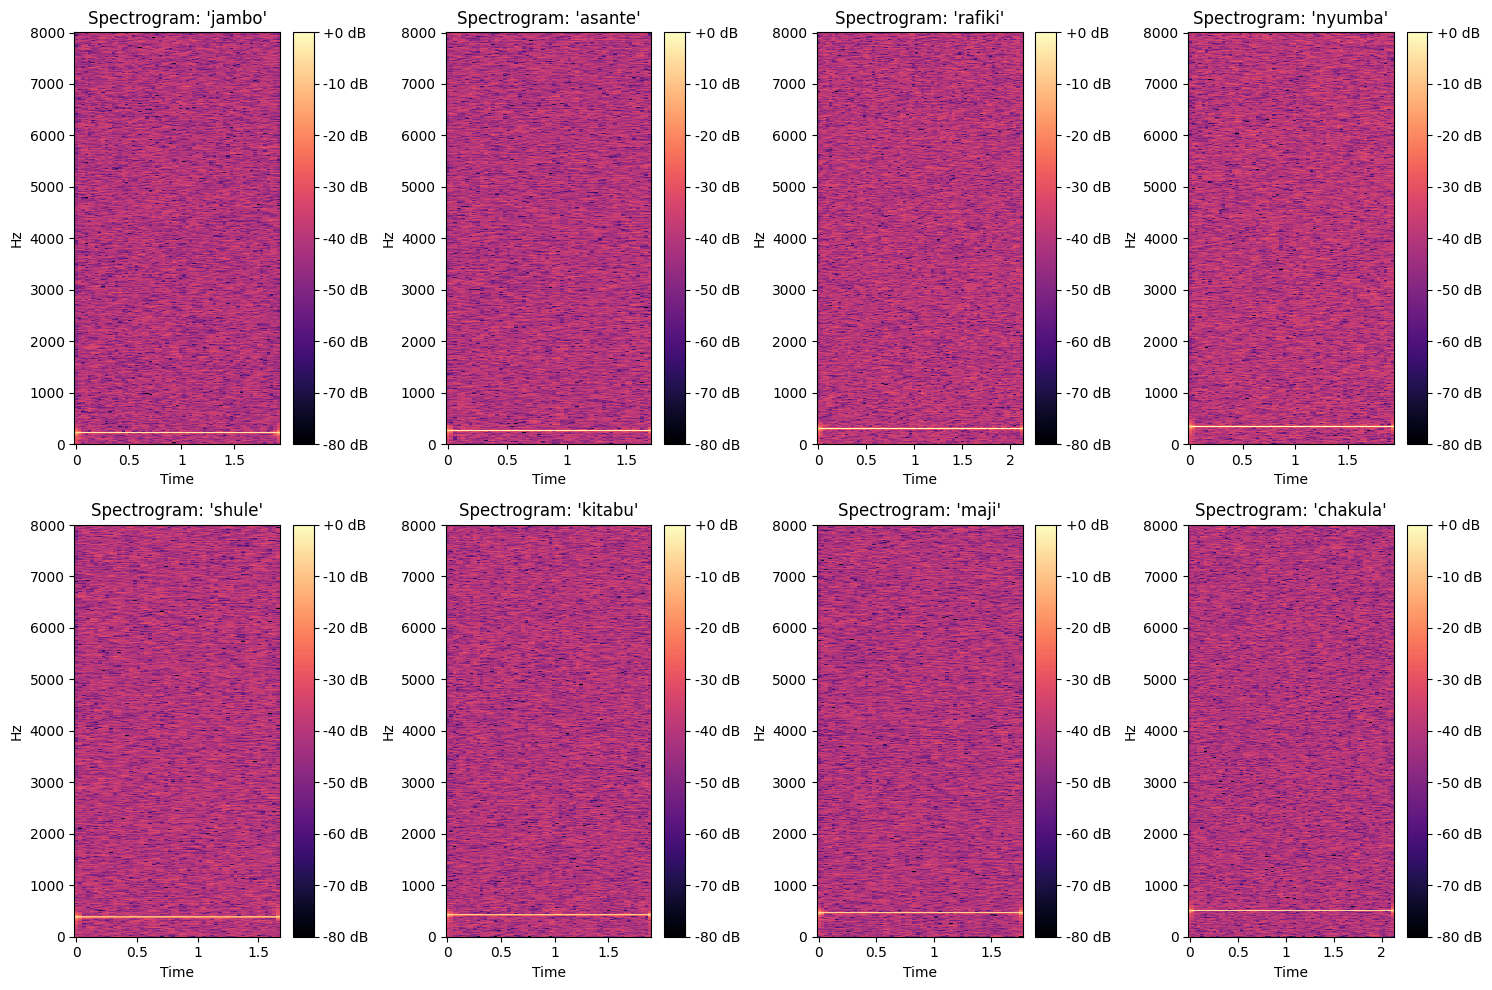

In [13]:
# Visualize spectrograms
plt.figure(figsize=(15, 10))
for i, (label, sample) in enumerate(class_samples.items()):
    plt.subplot(2, 4, i+1)
    audio_data = sample['audio']['array']
    sr = sample['audio']['sampling_rate']

    S = librosa.stft(audio_data)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.title(f"Spectrogram: '{label}'")
    plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [17]:
def extract_mfcc_features(audio_data, sr, n_mfcc=13):
    """Extract MFCC features from audio data"""
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=n_mfcc)
    return mfccs

def normalize_features(features):
    """Normalize features to zero mean and unit variance"""
    mean = np.mean(features, axis=1, keepdims=True)
    std = np.std(features, axis=1, keepdims=True)
    return (features - mean) / (std + 1e-8)

def add_noise(audio_data, noise_level=0.005):
    """Add random noise to audio data"""
    noise = np.random.normal(0, noise_level, audio_data.shape)
    return audio_data + noise

def pitch_shift(audio_data, sr, n_steps=2):
    """Pitch shift audio data"""
    return librosa.effects.pitch_shift(audio_data, sr=sr, n_steps=n_steps)

# Extract and normalize MFCC features for all samples
print("Extracting MFCC features...")
mfcc_features = {}

for split_name, samples in dataset.items():
    mfcc_features[split_name] = []
    for sample in samples:
        audio_data = sample['audio']['array']
        sr = sample['audio']['sampling_rate']

        # Extract MFCC
        mfcc = extract_mfcc_features(audio_data, sr)

        # Normalize
        mfcc_normalized = normalize_features(mfcc)

        mfcc_features[split_name].append({
            'features': mfcc_normalized,
            'label': sample['label'],
            'original_audio': audio_data
        })

print(f"MFCC features extracted: {len(mfcc_features['train'])} training, {len(mfcc_features['validation'])} validation")
print(f"MFCC shape example: {mfcc_features['train'][0]['features'].shape}")

Extracting MFCC features...
MFCC features extracted: 96 training, 24 validation
MFCC shape example: (13, 61)


In [18]:
# Fix the MFCC shape inconsistency by padding/truncating to fixed length
def fix_mfcc_length(mfcc_features, target_length=100):
    """Ensure all MFCC sequences have the same length"""
    fixed_features = []

    for sample in mfcc_features:
        features = sample['features']
        current_length = features.shape[1]

        if current_length < target_length:
            # Pad with zeros
            pad_width = target_length - current_length
            padded_features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
            fixed_features.append({
                'features': padded_features,
                'label': sample['label'],
                'original_audio': sample['original_audio']
            })
        elif current_length > target_length:
            # Truncate
            truncated_features = features[:, :target_length]
            fixed_features.append({
                'features': truncated_features,
                'label': sample['label'],
                'original_audio': sample['original_audio']
            })
        else:
            # Already correct length
            fixed_features.append(sample)

    return fixed_features

# Apply length fixing
print("Fixing MFCC sequence lengths...")
mfcc_features['train'] = fix_mfcc_length(mfcc_features['train'])
mfcc_features['validation'] = fix_mfcc_length(mfcc_features['validation'])

print(f"After fixing: Training samples: {len(mfcc_features['train'])}, Validation samples: {len(mfcc_features['validation'])}")
print(f"MFCC shape: {mfcc_features['train'][0]['features'].shape}")

Fixing MFCC sequence lengths...
After fixing: Training samples: 96, Validation samples: 24
MFCC shape: (13, 100)


In [19]:
# Data augmentation
print("Applying data augmentation...")

augmented_features = []
original_train_features = mfcc_features['train'].copy()

for sample in original_train_features:
    audio_data = sample['original_audio']
    sr = 16000
    label = sample['label']

    # Original features
    augmented_features.append(sample)

    # Add noise augmentation
    noisy_audio = add_noise(audio_data, noise_level=0.01)
    mfcc_noisy = extract_mfcc_features(noisy_audio, sr)
    mfcc_noisy_normalized = normalize_features(mfcc_noisy)
    mfcc_noisy_fixed = fix_mfcc_length([{'features': mfcc_noisy_normalized, 'label': label, 'original_audio': noisy_audio}])[0]
    augmented_features.append(mfcc_noisy_fixed)

    # Pitch shift augmentation
    pitched_audio = pitch_shift(audio_data, sr, n_steps=1)
    mfcc_pitched = extract_mfcc_features(pitched_audio, sr)
    mfcc_pitched_normalized = normalize_features(mfcc_pitched)
    mfcc_pitched_fixed = fix_mfcc_length([{'features': mfcc_pitched_normalized, 'label': label, 'original_audio': pitched_audio}])[0]
    augmented_features.append(mfcc_pitched_fixed)

# Replace training features with augmented set
mfcc_features['train'] = augmented_features
print(f"After augmentation: {len(mfcc_features['train'])} training samples")

Applying data augmentation...
After augmentation: 288 training samples


In [20]:
# Prepare data for modeling
def prepare_data_for_training(mfcc_features):
    X_train = np.array([sample['features'] for sample in mfcc_features['train']])
    y_train = np.array([sample['label'] for sample in mfcc_features['train']])

    X_val = np.array([sample['features'] for sample in mfcc_features['validation']])
    y_val = np.array([sample['label'] for sample in mfcc_features['validation']])

    return X_train, y_train, X_val, y_val

X_train, y_train, X_val, y_val = prepare_data_for_training(mfcc_features)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")

# Convert labels to numerical values
unique_labels = np.unique(y_train)
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

y_train_num = np.array([label_to_id[label] for label in y_train])
y_val_num = np.array([label_to_id[label] for label in y_val])

print(f"\nLabel mapping: {label_to_id}")

Training data shape: (288, 13, 100)
Training labels shape: (288,)
Validation data shape: (24, 13, 100)
Validation labels shape: (24,)

Label mapping: {np.str_('asante'): 0, np.str_('chakula'): 1, np.str_('jambo'): 2, np.str_('kitabu'): 3, np.str_('maji'): 4, np.str_('nyumba'): 5, np.str_('rafiki'): 6, np.str_('shule'): 7}


In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

print("Building 1D CNN model...")

# Prepare the data for CNN
# X_train shape: (samples, 13 MFCC coefficients, 100 time steps)
# We need to reshape for 1D CNN: (samples, 100 time steps, 13 features)
X_train_cnn = X_train.transpose(0, 2, 1)  # Change from (samples, 13, 100) to (samples, 100, 13)
X_val_cnn = X_val.transpose(0, 2, 1)

print(f"Reshaped training data: {X_train_cnn.shape}")
print(f"Reshaped validation data: {X_val_cnn.shape}")

# One-hot encode labels
y_train_categorical = to_categorical(y_train_num)
y_val_categorical = to_categorical(y_val_num)

print(f"One-hot encoded labels shape: {y_train_categorical.shape}")

Building 1D CNN model...
Reshaped training data: (288, 100, 13)
Reshaped validation data: (24, 100, 13)
One-hot encoded labels shape: (288, 8)


In [22]:
# Build 1D CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # First Conv1D layer
        layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),

        # Second Conv1D layer
        layers.Conv1D(128, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),

        # Third Conv1D layer
        layers.Conv1D(256, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),

        # Global pooling and dense layers
        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create model
input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])  # (100, 13)
num_classes = len(unique_labels)

model = create_cnn_model(input_shape, num_classes)

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model architecture:")
model.summary()

Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 98, 64)         │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 47, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 21, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,056 (633.03 KB)

 Trainable params: 160,904 (628.53 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [23]:
# Experiment with different kernel sizes
def create_cnn_model_variant(input_shape, num_classes, kernel_sizes=[3, 5, 3]):
    model = models.Sequential([
        # First Conv1D layer with variable kernel size
        layers.Conv1D(64, kernel_size=kernel_sizes[0], activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),

        # Second Conv1D layer with variable kernel size
        layers.Conv1D(128, kernel_size=kernel_sizes[1], activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),

        # Third Conv1D layer with variable kernel size
        layers.Conv1D(256, kernel_size=kernel_sizes[2], activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),

        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create variant with larger kernel sizes
model_variant = create_cnn_model_variant(input_shape, num_classes, kernel_sizes=[5, 7, 5])
model_variant.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Variant model with larger kernel sizes:")
model_variant.summary()

Variant model with larger kernel sizes:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 96, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 42, 128)        │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 42, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 17, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 17, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,024 (1023.53 KB)

 Trainable params: 260,872 (1019.03 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train model for 15 epochs
history = model.fit(
    X_train_cnn, y_train_categorical,
    batch_size=32,
    epochs=15,
    validation_data=(X_val_cnn, y_val_categorical),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.2854 - loss: 2.2176 - val_accuracy: 0.1250 - val_loss: 2.2094 - learning_rate: 7.8125e-06
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.2574 - loss: 2.2961 - val_accuracy: 0.1250 - val_loss: 2.2400 - learning_rate: 7.8125e-06
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2887 - loss: 2.2105 - val_accuracy: 0.1250 - val_loss: 2.2735 - learning_rate: 7.8125e-06
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3082 - loss: 1.9925 - val_accuracy: 0.1250 - val_loss: 2.3102 - learning_rate: 7.8125e-06
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2606 - loss: 2.2539 - val_accuracy: 0.1250 - val_loss: 2.3484 - learning_rate: 7.8125e-06
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3003 - loss: 2.2076 - val_accuracy: 0.1250 - val_loss: 2.3877 - learning_rate: 7.8125e-06
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3052 - loss: 2.184

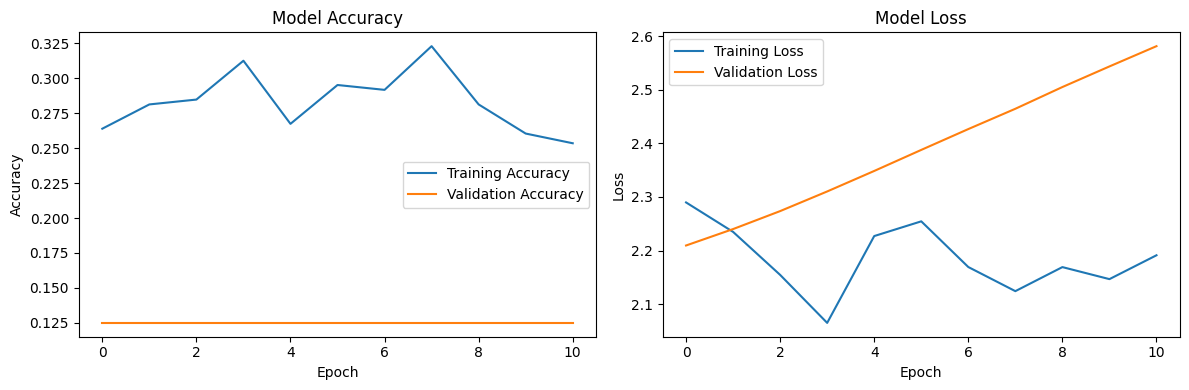

In [32]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
# Training results
final_epoch = len(history.history['accuracy'])
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Training completed in {final_epoch} epochs")

Final Training Accuracy: 0.2535
Final Validation Accuracy: 0.1250
Training completed in 11 epochs


In [42]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Make predictions
y_pred_proba = model.predict(X_val_cnn)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_val_categorical, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1-Score: {f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Validation Accuracy: 0.1250
Validation F1-Score: 0.0288


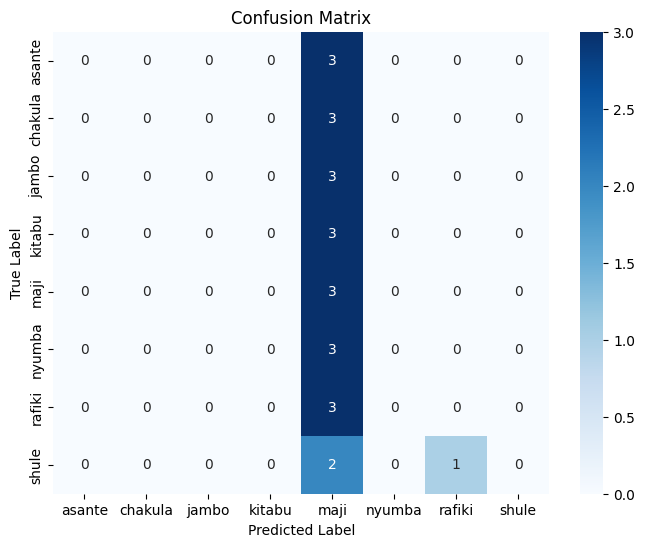

In [43]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels,
            yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [44]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=unique_labels))

Classification Report:
              precision    recall  f1-score   support

      asante       0.00      0.00      0.00         3
     chakula       0.00      0.00      0.00         3
       jambo       0.00      0.00      0.00         3
      kitabu       0.00      0.00      0.00         3
        maji       0.13      1.00      0.23         3
      nyumba       0.00      0.00      0.00         3
      rafiki       0.00      0.00      0.00         3
       shule       0.00      0.00      0.00         3

    accuracy                           0.12        24
   macro avg       0.02      0.12      0.03        24
weighted avg       0.02      0.12      0.03        24



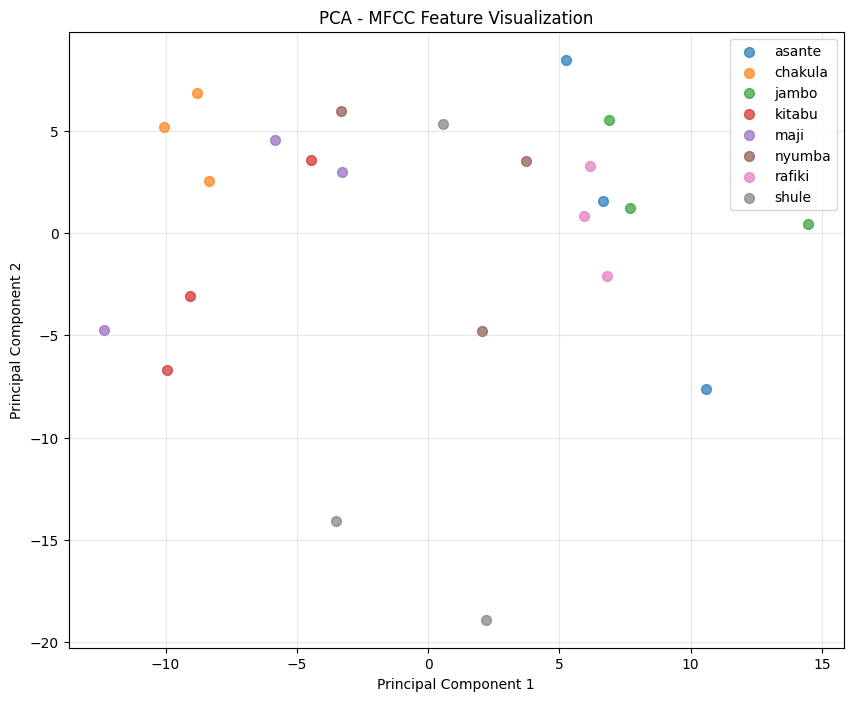

PCA explained variance: [0.0819415  0.06463168]


In [45]:
# Visualize embeddings via PCA - Fixed version
from sklearn.decomposition import PCA

# Use the raw MFCC features for PCA visualization
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Apply PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(X_val_flat)

# Plot PCA
plt.figure(figsize=(10, 8))
for i, label in enumerate(unique_labels):
    mask = y_true == i
    plt.scatter(embeddings_pca[mask, 0], embeddings_pca[mask, 1], label=label, alpha=0.7, s=50)
plt.title('PCA - MFCC Feature Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"PCA explained variance: {pca.explained_variance_ratio_}")

In [47]:
# Fix the function first
def fix_mfcc_length_simple(mfcc_features, target_length=100):
    """Ensure all MFCC sequences have the same length"""
    fixed_features = []

    for sample in mfcc_features:
        features = sample['features']
        current_length = features.shape[1]

        if current_length < target_length:
            # Pad with zeros
            pad_width = target_length - current_length
            padded_features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
            fixed_features.append({
                'features': padded_features,
                'label': sample['label']
            })
        elif current_length > target_length:
            # Truncate
            truncated_features = features[:, :target_length]
            fixed_features.append({
                'features': truncated_features,
                'label': sample['label']
            })
        else:
            # Already correct length
            fixed_features.append(sample)

    return fixed_features

# Test different MFCC parameters
def test_mfcc_parameters(audio_data, sr, n_mfcc=13, n_fft=2048, hop_length=512):
    """Extract MFCC with different parameters"""
    mfcc = librosa.feature.mfcc(
        y=audio_data,
        sr=sr,
        n_mfcc=n_mfcc,
        n_fft=n_fft,
        hop_length=hop_length
    )
    return mfcc

# Test different configurations
configs = [
    {'n_mfcc': 13, 'n_fft': 2048, 'hop_length': 512, 'name': 'Default'},
    {'n_mfcc': 20, 'n_fft': 2048, 'hop_length': 512, 'name': 'More MFCCs'},
    {'n_mfcc': 13, 'n_fft': 1024, 'hop_length': 256, 'name': 'Higher Resolution'}
]

print("Testing different MFCC configurations...")
results = []

for config in configs:
    print(f"\nTesting {config['name']}...")

    # Extract features with current config
    features_list = []
    labels_list = []

    for split_name, samples in dataset.items():
        for sample in samples:
            audio_data = sample['audio']['array']
            sr = sample['audio']['sampling_rate']

            mfcc = test_mfcc_parameters(audio_data, sr,
                                      n_mfcc=config['n_mfcc'],
                                      n_fft=config['n_fft'],
                                      hop_length=config['hop_length'])

            # Normalize
            mfcc_normalized = normalize_features(mfcc)

            # Fix length
            mfcc_fixed = fix_mfcc_length_simple([{'features': mfcc_normalized, 'label': sample['label']}])[0]
            features_list.append(mfcc_fixed['features'])
            labels_list.append(mfcc_fixed['label'])

    # Prepare data
    X_all = np.array(features_list)
    X_all_cnn = X_all.transpose(0, 2, 1)

    # Split back to train/val
    split_idx = len(dataset['train'])
    X_train_new = X_all_cnn[:split_idx]
    X_val_new = X_all_cnn[split_idx:]

    # Convert labels to numerical
    y_train_new_num = np.array([label_to_id[label] for label in labels_list[:split_idx]])
    y_val_new_num = np.array([label_to_id[label] for label in labels_list[split_idx:]])
    y_train_new_cat = to_categorical(y_train_new_num)
    y_val_new_cat = to_categorical(y_val_new_num)

    # Train a simple model for quick evaluation
    simple_model = create_cnn_model(X_train_new.shape[1:], num_classes)
    simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Quick training
    history_simple = simple_model.fit(
        X_train_new, y_train_new_cat,
        batch_size=32,
        epochs=8,
        validation_data=(X_val_new, y_val_new_cat),
        verbose=0
    )

    # Store results
    final_val_acc = history_simple.history['val_accuracy'][-1]
    results.append({
        'config': config['name'],
        'n_mfcc': config['n_mfcc'],
        'n_fft': config['n_fft'],
        'hop_length': config['hop_length'],
        'val_accuracy': final_val_acc,
        'feature_shape': X_train_new[0].shape
    })

    print(f"  Validation Accuracy: {final_val_acc:.4f}")
    print(f"  Feature Shape: {X_train_new[0].shape}")

Testing different MFCC configurations...

Testing Default...
  Validation Accuracy: 0.1667
  Feature Shape: (100, 13)

Testing More MFCCs...
  Validation Accuracy: 0.0833
  Feature Shape: (100, 20)

Testing Higher Resolution...
  Validation Accuracy: 0.2083
  Feature Shape: (100, 13)



MFCC Configuration Comparison:
              config  n_mfcc  n_fft  hop_length  val_accuracy
0            Default      13   2048         512      0.166667
1         More MFCCs      20   2048         512      0.083333
2  Higher Resolution      13   1024         256      0.208333


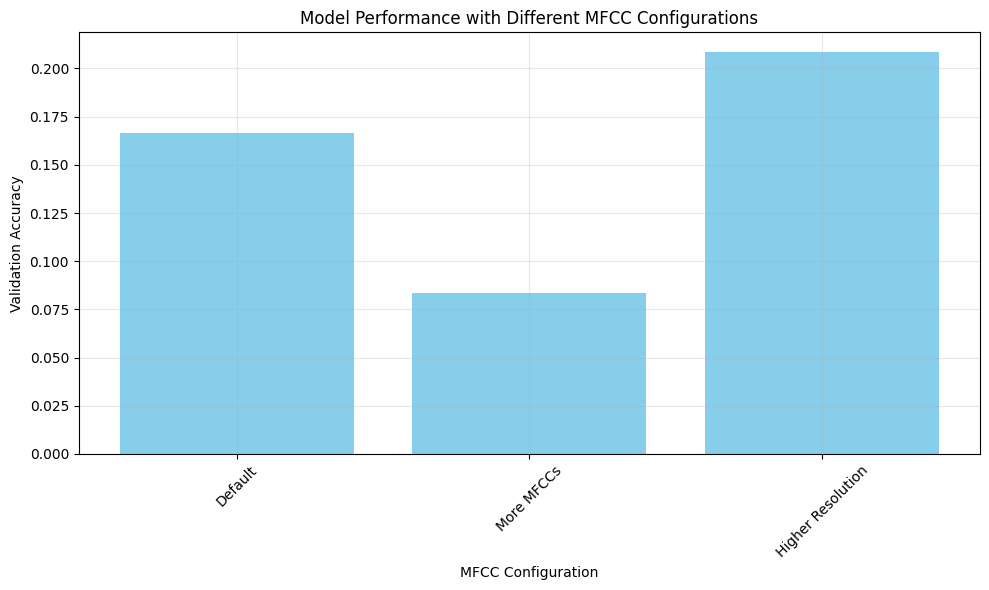

In [48]:
# Compare results
results_df = pd.DataFrame(results)
print("\nMFCC Configuration Comparison:")
print("=" * 50)
print(results_df[['config', 'n_mfcc', 'n_fft', 'hop_length', 'val_accuracy']])

# Plot comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df['config'], results_df['val_accuracy'], color='skyblue')
plt.title('Model Performance with Different MFCC Configurations')
plt.xlabel('MFCC Configuration')
plt.ylabel('Validation Accuracy')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [49]:
# Test different sampling rates
def resample_audio(audio_data, original_sr, target_sr):
    """Resample audio to target sampling rate"""
    return librosa.resample(audio_data, orig_sr=original_sr, target_sr=target_sr)

sampling_rates = [8000, 16000, 22050]
sampling_results = []

print("Testing different sampling rates...")

for target_sr in sampling_rates:
    print(f"\nTesting sampling rate: {target_sr} Hz")

    features_list = []
    labels_list = []

    for split_name, samples in dataset.items():
        for sample in samples:
            audio_data = sample['audio']['array']
            original_sr = sample['audio']['sampling_rate']

            # Resample audio
            if original_sr != target_sr:
                audio_resampled = resample_audio(audio_data, original_sr, target_sr)
            else:
                audio_resampled = audio_data

            # Extract MFCC with resampled audio
            mfcc = extract_mfcc_features(audio_resampled, target_sr)
            mfcc_normalized = normalize_features(mfcc)
            mfcc_fixed = fix_mfcc_length_simple([{'features': mfcc_normalized, 'label': sample['label']}])[0]

            features_list.append(mfcc_fixed['features'])
            labels_list.append(mfcc_fixed['label'])

    # Prepare and evaluate
    X_all = np.array(features_list)
    X_all_cnn = X_all.transpose(0, 2, 1)

    split_idx = len(dataset['train'])
    X_train_sr = X_all_cnn[:split_idx]
    X_val_sr = X_all_cnn[split_idx:]

    y_train_sr_num = np.array([label_to_id[label] for label in labels_list[:split_idx]])
    y_val_sr_num = np.array([label_to_id[label] for label in labels_list[split_idx:]])
    y_train_sr_cat = to_categorical(y_train_sr_num)
    y_val_sr_cat = to_categorical(y_val_sr_num)

    simple_model = create_cnn_model(X_train_sr.shape[1:], num_classes)
    simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history_sr = simple_model.fit(
        X_train_sr, y_train_sr_cat,
        batch_size=32,
        epochs=8,
        validation_data=(X_val_sr, y_val_sr_cat),
        verbose=0
    )

    final_val_acc = history_sr.history['val_accuracy'][-1]
    sampling_results.append({
        'sampling_rate': target_sr,
        'val_accuracy': final_val_acc
    })

    print(f"  Validation Accuracy: {final_val_acc:.4f}")

Testing different sampling rates...

Testing sampling rate: 8000 Hz
  Validation Accuracy: 0.0833

Testing sampling rate: 16000 Hz
  Validation Accuracy: 0.1250

Testing sampling rate: 22050 Hz
  Validation Accuracy: 0.1250



Sampling Rate Comparison:
   sampling_rate  val_accuracy
0           8000      0.083333
1          16000      0.125000
2          22050      0.125000


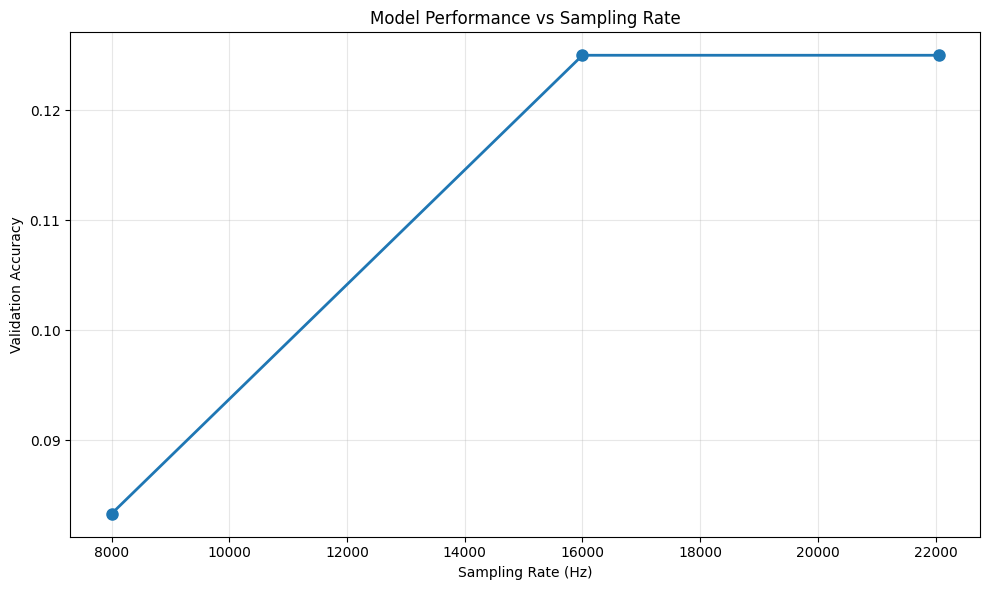

In [50]:
# Plot sampling rate results
sampling_df = pd.DataFrame(sampling_results)
print("\nSampling Rate Comparison:")
print("=" * 40)
print(sampling_df)

plt.figure(figsize=(10, 6))
plt.plot(sampling_df['sampling_rate'], sampling_df['val_accuracy'], 'o-', linewidth=2, markersize=8)
plt.title('Model Performance vs Sampling Rate')
plt.xlabel('Sampling Rate (Hz)')
plt.ylabel('Validation Accuracy')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [62]:
# Install required packages for ASR
!pip install transformers torch

In [63]:
# Import required libraries
from transformers import pipeline, AutoModelForSpeechSeq2Seq, AutoProcessor
import torch

In [64]:
# Initialize ASR pipeline
print("Loading Automatic Speech Recognition (ASR) model...")
asr_pipeline = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-tiny",
    torch_dtype=torch.float32
)

Loading Automatic Speech Recognition (ASR) model...


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

Device set to use cpu


In [65]:
# Test ASR on sample audio
print("Testing ASR on sample audio...")
print("=" * 40)

# Test on 3 samples
for i in range(3):
    sample = dataset['train'][i]
    audio_data = sample['audio']['array']
    sampling_rate = sample['audio']['sampling_rate']
    true_label = sample['label']

    # Run ASR
    result = asr_pipeline({
        "raw": audio_data,
        "sampling_rate": sampling_rate
    })

    recognized_text = result["text"].strip()

    print(f"Sample {i+1}:")
    print(f"  True label: '{true_label}'")
    print(f"  Recognized text: '{recognized_text}'")
    print()

Testing ASR on sample audio...


`return_token_timestamps` is deprecated for WhisperFeatureExtractor and will be removed in Transformers v5. Use `return_attention_mask` instead, as the number of frames can be inferred from it.
Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.


Sample 1:
  True label: 'jambo'
  Recognized text: 'Okay.'

Sample 2:
  True label: 'jambo'
  Recognized text: 'Yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, 

In [66]:
# Initialize text sentiment classifier
print("Loading text sentiment classifier...")
sentiment_classifier = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    return_all_scores=True
)

Loading text sentiment classifier...


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


In [67]:
# Create combined pipeline
def speech_to_sentiment_pipeline(audio_data, sampling_rate):
    """Complete pipeline: Speech -> Text -> Sentiment"""
    # Step 1: Automatic Speech Recognition
    asr_result = asr_pipeline({
        "raw": audio_data,
        "sampling_rate": sampling_rate
    })
    recognized_text = asr_result["text"].strip()

    # Step 2: Sentiment Analysis
    if recognized_text and len(recognized_text) > 1:  # Check if text is meaningful
        sentiment_scores = sentiment_classifier(recognized_text)[0]
        # Get the sentiment with highest score
        best_sentiment = max(sentiment_scores, key=lambda x: x['score'])
        return {
            'recognized_text': recognized_text,
            'sentiment': best_sentiment['label'],
            'confidence': best_sentiment['score'],
            'all_scores': sentiment_scores
        }
    else:
        return {
            'recognized_text': recognized_text,
            'sentiment': 'UNKNOWN',
            'confidence': 0.0,
            'all_scores': []
        }

In [68]:
# Test complete pipeline
print("Testing Complete Speech-to-Text + Sentiment Pipeline")
print("=" * 60)

pipeline_results = []

for i in range(5):
    sample = dataset['train'][i]
    audio_data = sample['audio']['array']
    sampling_rate = sample['audio']['sampling_rate']
    true_label = sample['label']

    # Run complete pipeline
    result = speech_to_sentiment_pipeline(audio_data, sampling_rate)

    pipeline_results.append({
        'true_label': true_label,
        'recognized_text': result['recognized_text'],
        'sentiment': result['sentiment'],
        'confidence': result['confidence']
    })

    print(f"Sample {i+1}:")
    print(f"  True word: '{true_label}'")
    print(f"  ASR output: '{result['recognized_text']}'")
    print(f"  Sentiment: {result['sentiment']} (confidence: {result['confidence']:.3f})")
    print()

Testing Complete Speech-to-Text + Sentiment Pipeline
Sample 1:
  True word: 'jambo'
  ASR output: 'Okay.'
  Sentiment: neutral (confidence: 0.569)

Sample 2:
  True word: 'jambo'
  ASR output: 'Yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, yeah, ye

In [69]:
# Analyze pipeline performance
print("Pipeline Performance Analysis:")
print("=" * 40)

successful_asr = 0
sentiment_distribution = {}

for result in pipeline_results:
    text = result['recognized_text']
    sentiment = result['sentiment']

    if text and len(text) > 1:  # Meaningful text recognized
        successful_asr += 1

    if sentiment in sentiment_distribution:
        sentiment_distribution[sentiment] += 1
    else:
        sentiment_distribution[sentiment] = 1

total_samples = len(pipeline_results)
asr_success_rate = successful_asr / total_samples

print(f"Total samples processed: {total_samples}")
print(f"Successful ASR: {successful_asr} ({asr_success_rate:.1%})")
print(f"Sentiment distribution: {sentiment_distribution}")

Pipeline Performance Analysis:
Total samples processed: 5
Successful ASR: 5 (100.0%)
Sentiment distribution: {'neutral': 4, 'positive': 1}


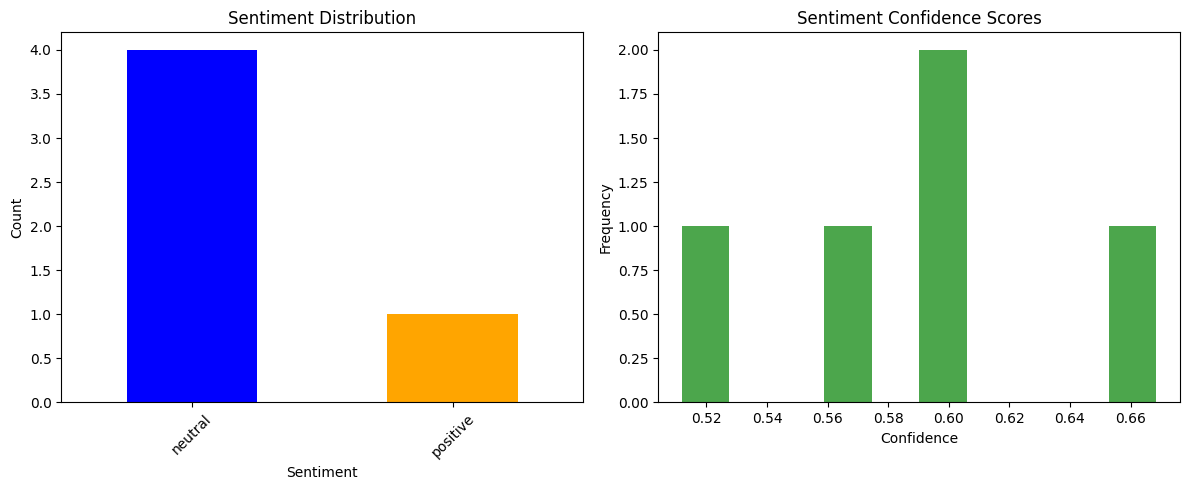

In [70]:
# Visualize pipeline results
import pandas as pd

pipeline_df = pd.DataFrame(pipeline_results)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Sentiment distribution
sentiment_counts = pipeline_df['sentiment'].value_counts()
sentiment_counts.plot(kind='bar', ax=ax1, color=['blue', 'orange', 'red', 'gray'])
ax1.set_title('Sentiment Distribution')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Confidence scores
if len(pipeline_df) > 0:
    ax2.hist(pipeline_df['confidence'], bins=10, alpha=0.7, color='green')
    ax2.set_title('Sentiment Confidence Scores')
    ax2.set_xlabel('Confidence')
    ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [71]:
# Final demonstration
print("FINAL PIPELINE DEMONSTRATION")
print("=" * 50)

demo_sample = dataset['train'][0]
demo_audio = demo_sample['audio']['array']
demo_sr = demo_sample['audio']['sampling_rate']
demo_label = demo_sample['label']

print(f"Processing Swahili word: '{demo_label}'")
print("-" * 40)

# Step-by-step pipeline execution
print("1. Automatic Speech Recognition...")
asr_result = asr_pipeline({"raw": demo_audio, "sampling_rate": demo_sr})
recognized_text = asr_result["text"].strip()
print(f"   ASR Output: '{recognized_text}'")

print("2. Sentiment Analysis...")
if recognized_text and len(recognized_text) > 1:
    sentiment_results = sentiment_classifier(recognized_text)[0]
    for sentiment in sentiment_results:
        print(f"   {sentiment['label']}: {sentiment['score']:.3f}")

    best_sentiment = max(sentiment_results, key=lambda x: x['score'])
    print(f"   Final Sentiment: {best_sentiment['label']} (confidence: {best_sentiment['score']:.3f})")
else:
    print("   No meaningful text for sentiment analysis")

print("\n✅ Pipeline execution completed!")

FINAL PIPELINE DEMONSTRATION
Processing Swahili word: 'jambo'
----------------------------------------
1. Automatic Speech Recognition...
   ASR Output: 'Okay.'
2. Sentiment Analysis...
   negative: 0.075
   neutral: 0.569
   positive: 0.356
   Final Sentiment: neutral (confidence: 0.569)

✅ Pipeline execution completed!
